In [66]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [67]:
data = pd.read_csv('/content/drive/MyDrive/딥러닝 파이토치 교과서/LSTM STOCKS/AAPL.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [68]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [69]:
data['Volume'] = data['Volume'].astype(float)

In [70]:
X = data.iloc[:, :-1]
Y = data.iloc[:, 5:6]
print(X)
print(Y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2021-03-22  120.330002  123.870003  120.260002  123.389999  122.660965
2021-03-23  123.330002  124.239998  122.139999  122.540001  121.815987
2021-03-24  122.820000  122.900002  120.070000  120.089996  119.380455
2021-03-25  119.540001  121.660004  119.000000  120.589996  119.877495
2021-03-26  120.349998  121.480003  118.919998  121.209999  120.493843
...                ...         ...         ...         ...         ...
2022-03-15  150.899994  155.570007  150.380005  155.089996  155.089996
2022-03-16  157.050003  160.000000  154.460007  159.589996  159.589996
2022-03-17  158.610001  161.000000  157.630005  160.619995  160.619995
2022-03-18  160.509995  164.479996  159.759995  163.979996  163.979996
2022-03-18  160.509995  164.479996  159.759995  163.979996  163.979996

[253 rows x 5 columns]
                 Volume
Date                   
2021-

In [71]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
Y_ms = ms.fit_transform(Y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

Y_train = Y_ms[:200, :]
Y_test = Y_ms[200:, :]

print("Training Shape", X_train.shape, Y_train.shape)
print("Testing Shape", X_test.shape, Y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [72]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

Y_train_tensors = torch.Tensor(Y_train)
Y_test_tensors = torch.Tensor(Y_test)

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, Y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, Y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [73]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super().__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    output, (hn, cn) = self.lstm(x, (h_0, c_0))
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [74]:
num_epochs = 15000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, Y_train_tensors)
  loss.backward()

  optimizer.step()
  if epoch % 1000 == 0:
    print(f'Epoch: {epoch} Loss: {loss.item():.5f}')

Epoch: 0 Loss: 0.04011
Epoch: 1000 Loss: 0.02296
Epoch: 2000 Loss: 0.02164
Epoch: 3000 Loss: 0.02052
Epoch: 4000 Loss: 0.01449
Epoch: 5000 Loss: 0.01133
Epoch: 6000 Loss: 0.01125
Epoch: 7000 Loss: 0.01119
Epoch: 8000 Loss: 0.01113
Epoch: 9000 Loss: 0.01107
Epoch: 10000 Loss: 0.01100
Epoch: 11000 Loss: 0.01094
Epoch: 12000 Loss: 0.01088
Epoch: 13000 Loss: 0.01082
Epoch: 14000 Loss: 0.01077


In [76]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = torch.Tensor(df_x_ss)
df_y_ms = torch.Tensor(df_y_ms)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

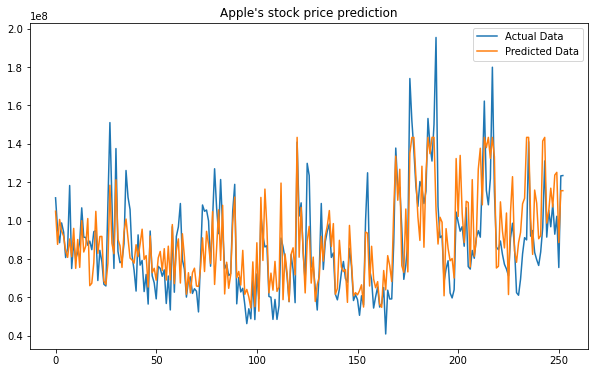

In [78]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title("Apple's stock price prediction")
plt.legend()
plt.show()